<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer 
import string
from nltk import word_tokenize, pos_tag
import re
from itertools import product
import warnings
from joblib import dump, load
from nltk.tokenize import sent_tokenize
import gc
from tqdm import tqdm, tqdm_notebook, notebook
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
warnings.filterwarnings('ignore')

# зафиксируем псевдослучайность 
rnd_state = 12345

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# загрузим данные
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# изучим файл
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.sample(10, random_state=rnd_state)

,Unnamed: 0,text,toxic
109486,109583,Expert Categorizers \n\nWhy is there no menti...,0
104980,105077,"""\n\n Noise \n\nfart* talk. """,1
82166,82244,"An indefinite block is appropriate, even for a...",0
18721,18740,I don't understand why we have a screenshot of...,0
128178,128310,"Hello! Some of the people, places or things yo...",0
108309,108406,"""::::::::::::::If you read carefully, my comme...",1
25259,25283,"""\nDid you make it at WP:AE? ofShalott """,0
32655,32695,know as much as he thinks.,0
31896,31936,Thank you for your comment and willingness to ...,0
20224,20244,UPDATE 3-12-06\n\nHEY YALL IM GOING TO BE GONE...,0


In [5]:
# убедимся, что единица соответсвует токсичным комментарием
data.query('toxic == 1').head()

,Unnamed: 0,text,toxic
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,16,"Bye! \n\nDon't look, come or think of comming ...",1
42,42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [6]:
# посмотрим на размер датасета
print(data.shape)

(159292, 3)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


>В нашем распоряжении набор данных с разметкой о токсичности правок к описанию товаров интернет-магазина «Викишоп». 
Данные находятся в файле /datasets/toxic_comments.csv.
Столбец text содержит текст комментария, а toxic — целевой признак. В целевом признаке 1 - токсичный комментарий, 0 - обычный.

### Анализ данных

In [8]:
# проверим данные на пропуски
data.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

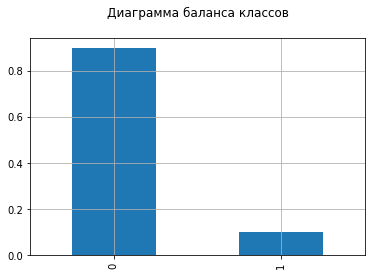

In [9]:
# посмотрим на баланс классов, построим столбчатую диаграмму
data['toxic'].value_counts(normalize=True).plot(kind='bar', grid=True)

plt.title('Диаграмма баланса классов'+ "\n")
plt.show()

>Классы несбалансированны, когда их соотношение далеко от 1:1. Баланс классов (англ. class balance) наблюдается, если их количество примерно равно. Проверка показала, что классы распределены неравномерно, токсичные коментарии составляют 1/9 от выборки.

Прежде чем извлечь признаки из текста, упростим его.

Этапы предобработки текста:
- Токенизация каждого текста, то есть разбиваем его на слова
- Лемматизация, приведем к начальной словарной форме
- Очистка от стоп-слов и ненужных символов

In [10]:
stop_words = set(nltk_stopwords.words('english'))
punctuation = string.punctuation 
wordnet_lemmatizer = WordNetLemmatizer()

In [11]:
def tokenizer(text):
    tokens = [ word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    tokens = list(filter(lambda t: t not in punctuation, tokens)) 
    tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
    filtered_tokens = []
    for token in tokens: 
        if re.search('[a-zA-Z]', token): 
            filtered_tokens.append(token)
    filtered_tokens = list(
        map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens))
    filtered_tokens = list(filter(lambda t: t not in punctuation, filtered_tokens))
    return ' '.join(filtered_tokens)

In [12]:
%%time
data['text_clean'] = data['text'].map(tokenizer)

CPU times: user 2min 19s, sys: 416 ms, total: 2min 19s
Wall time: 2min 20s


In [13]:
# создадим функцию, которая разобъет данные на выборки
def split_train_test_valid(dataframe, test_size, valid_size):
    
    data_train, data_test = train_test_split(
        dataframe,
        test_size=test_size,
        shuffle = False,
        
    )
    
    post_split_valid_size = valid_size / (1 - test_size)
    data_train, data_valid = train_test_split(
        data_train,
        test_size=post_split_valid_size,
        shuffle =False ,
        
    )
    return data_train, data_test, data_valid

In [14]:
data_train, data_test, data_valid = split_train_test_valid(data, 0.1, 0.2)

print(data_train.shape, data_test.shape, data_valid.shape)

(111503, 4) (15930, 4) (31859, 4)


## Обучение

- Разобьем данные на обучающую, тестовую и валидационную выборки.
- Разделим данные на признаки и целевые признаки.
- Получим TF-IDF для корпуса текста.
- Обучим разные модели.
- Протестируем модель с лучшим показателем F1 метрики.

Необходимо построить модель со значением метрики качества F1 не меньше 0.75.

In [15]:
train_corpus = data_train['text_clean'].values.astype('U')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

# посчитаем TF-IDF для корпуса текстов
tfidf_train = count_tf_idf.fit_transform(train_corpus)

In [16]:
# определение таргета для обучения моделей
target_train = data_train['toxic']

In [ ]:
valid_target = data_valid['toxic']
valid_corpus = data_valid['text_clean'].values.astype('U')
tfidf_valid = count_tf_idf.transform(valid_corpus)

- **Модель LogisticRegression**

In [ ]:
%%time

f1_logic = dict()
for i in product([{'penalty':'l1'},{'penalty':'l2'}],
              [{'max_iter':2},{ 'max_iter':5}, {'max_iter':100}]
              ):
    model_logic = LogisticRegression(random_state = rnd_state,**i[0],**i[1])
    model_logic.fit(tfidf_train, target_train)
    predicted_logic = model_logic.predict(tfidf_valid)
    f1_logic = f1_score(valid_target, predicted_logic)
    print('i=', i, 'f1_logic', f1_logic)

In [ ]:
model = LogisticRegression(random_state=rnd_state, solver='liblinear')
model.fit(tfidf_train, target_train)
predicted_logic = model.predict(tfidf_valid)
f1_logic = f1_score(valid_target, predicted_logic)
print(f1_logic)

- **Модель LinearSVC**

In [ ]:
%%time

f1_svc = dict()
for i in product([{'C':0.1},{'C':1.0} ,{'C':2.5}],
              [{'max_iter':5},{ 'max_iter':10}, {'max_iter':100}]
              ):
    model_svc = LinearSVC(random_state = rnd_state,**i[0],**i[1])
    model_svc.fit(tfidf_train, target_train)
    predicted_svc = model_svc.predict(tfidf_valid)
    f1_svc = f1_score(valid_target, predicted_svc)
    print('i=', i, 'f1_svc', f1_svc)

- **Модель RidgeClassifier**

In [ ]:
%%time

model_clf = RidgeClassifier(alpha = 1, normalize = True)
model_clf.fit(tfidf_train, target_train)
predicted_clf = model_clf.predict(tfidf_valid)
f1_clf = f1_score(valid_target, predicted_clf)
f1_clf

>Исходя из анализа: можно сделать вывод, что модель "LinearSVC" с параметрами i= ({'C': 1.0}, {'max_iter': 5}) f1_svc 0.7855034437520498 наиболее подходящая. Далее проведем тестирование.

## Выводы

### Тестирование модели

In [ ]:
test_target = data_test['toxic'] 
test_corpus = data_test['text_clean'].values.astype('U') 

tfidf_test = count_tf_idf.transform(test_corpus) 

best_model = LinearSVC(random_state = rnd_state,  max_iter= 5) 

best_model.fit(tfidf_train, target_train)
predicted_test = best_model.predict(tfidf_test) 
f1 = f1_score(test_target, predicted_test) 
f1

>**В ходе исследования данных получены следующие результаты:**
>- данные были загружены и исследованы
>- установлен дисбаланс классов, токсичные комментарии составляют 10% 
>- произведена предобработка данных (токенизация, лемматизация, очистка от стоп-слов)
>- обучены три модели (LogisticRegression, LinearSVC, RidgeClassifier)
>- лучший результат F1 метрики показала модель LinearSVC
>- провели тестирование модели на тестовой выборке
>- заданное значение метрики F1 получено